In [228]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from gplearn.genetic import SymbolicRegressor
import graphviz
from sklearn.metrics import r2_score, mean_absolute_error

In [229]:
passengers = pd.read_csv("passengers.csv")
passengers.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [230]:
# превратим дату в индекс и сделаем изменение постоянным
passengers.set_index('Month', inplace = True)
passengers.head()

,#Passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121


In [231]:
CELEVOY_PRIZNAK = '#Passengers'

In [232]:
# превратим дату (наш индекс) в объект datetime
passengers.index = pd.to_datetime(passengers.index)
 
# посмотрим на первые пять дат и на тип данных
passengers.index[:5]

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01'],
              dtype='datetime64[ns]', name='Month', freq=None)

теперь мы можем делать срезы по периодам

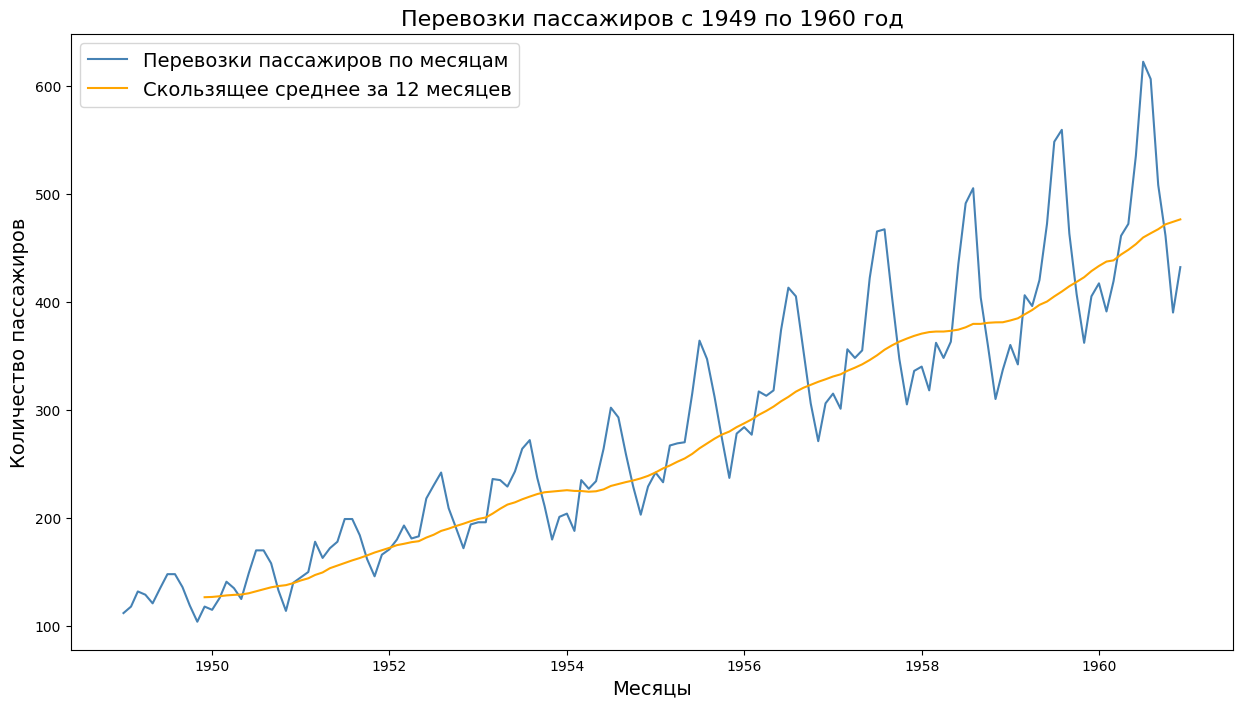

In [233]:
# зададим размер графика
plt.figure(figsize = (15,8))
 
# поочередно зададим кривые (перевозки и скользящее среднее) с подписями и цветом
plt.plot(passengers, label = 'Перевозки пассажиров по месяцам', color = 'steelblue')
plt.plot(passengers.rolling(window = 12).mean(), label = 'Скользящее среднее за 12 месяцев', color = 'orange')
 
# добавим легенду, ее положение на графике и размер шрифта
plt.legend(title = '', loc = 'upper left', fontsize = 14)
 
# добавим подписи к осям и заголовки
plt.xlabel('Месяцы', fontsize = 14)
plt.ylabel('Количество пассажиров', fontsize = 14)
plt.title('Перевозки пассажиров с 1949 по 1960 год', fontsize = 16)
 
# выведем обе кривые на одном графике
plt.show()

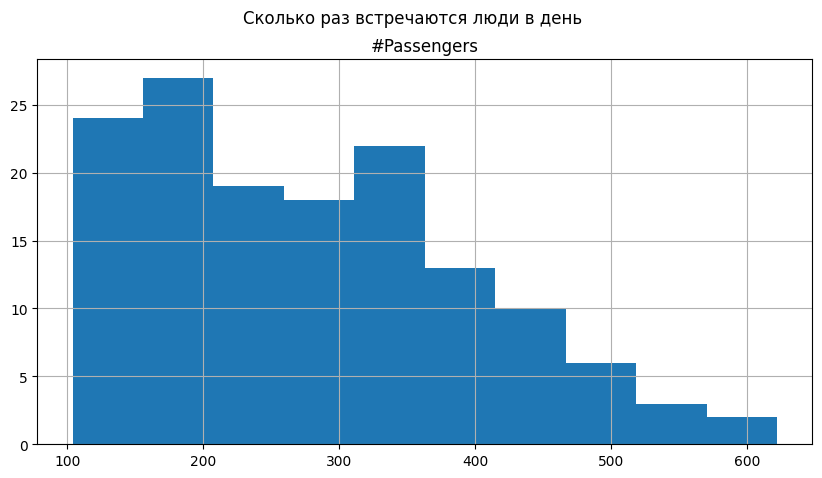

In [234]:
fig, ax = plt.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Сколько раз встречаются люди в день')
passengers.hist(ax=ax, legend=False)
plt.show()

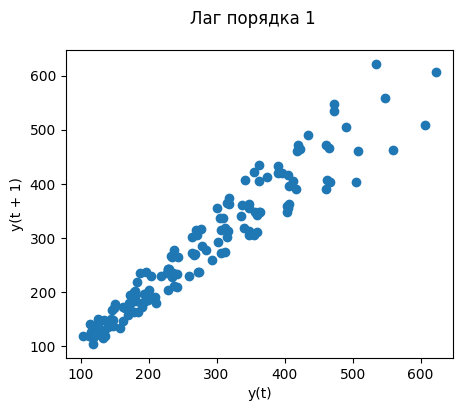

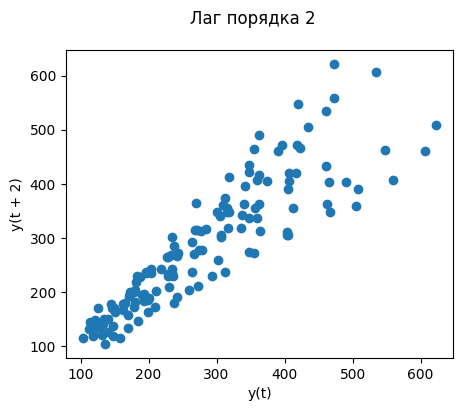

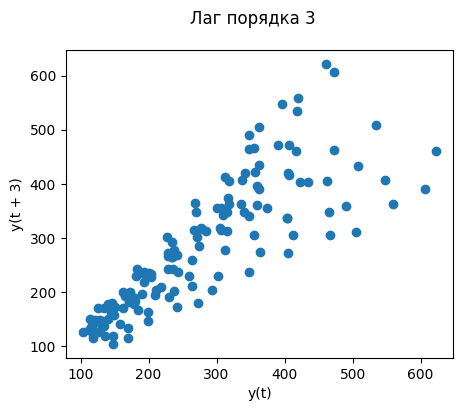

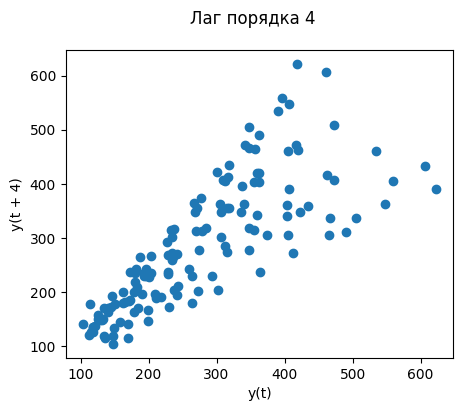

In [235]:
for i in range(1, 5):
    fig, ax = plt.subplots(1, 1, sharex='col', sharey='row', figsize=(5,4))
    fig.suptitle(f'Лаг порядка {i}')
    pd.plotting.lag_plot(passengers, lag=i, ax=ax)
    plt.show()

имеет место положительная автокорреляция

In [236]:
def plot_decompose(data=passengers['#Passengers'], model='add'):
    result_add = seasonal_decompose(data, model = 'add')
    fig = result_add.plot()
    fig.set_size_inches((10, 8))
    # Перерисовка
    fig.tight_layout()
    plt.show()

разделим на тенденции, цикличность и случайные колебания

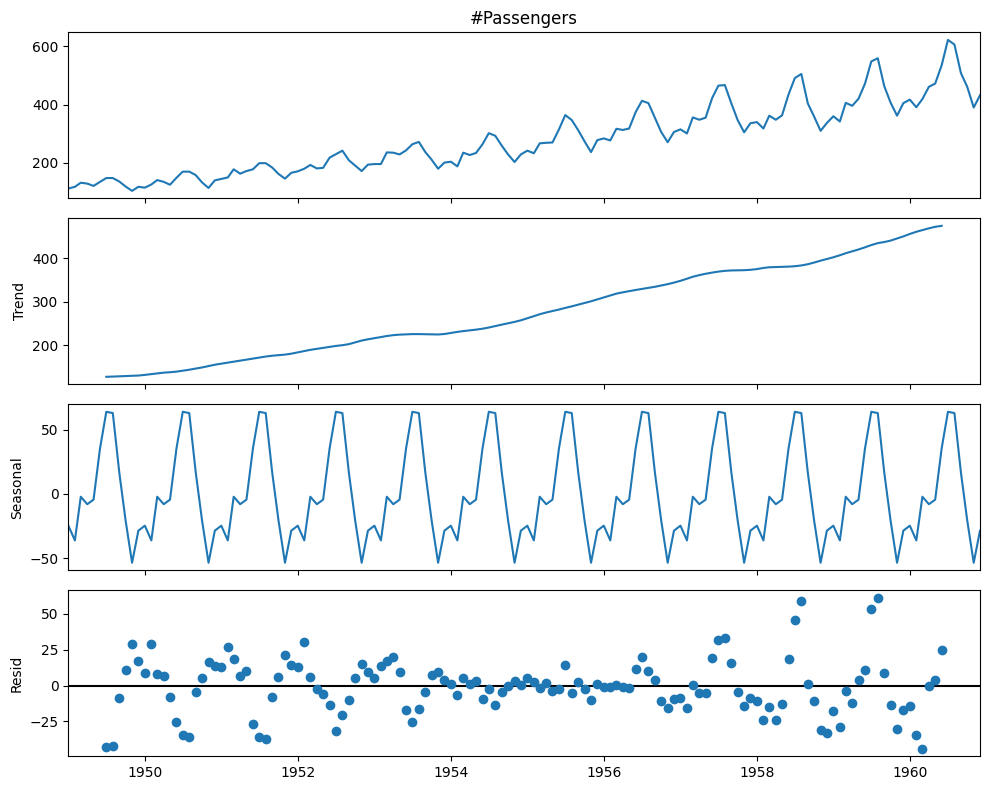

In [237]:
plot_decompose(data=passengers['#Passengers'], model='add')

разделим на обучающую и тестовую выборку

# Прогнозирование временного ряда авторегрессионными методами

In [238]:
# Целочисленная метка шкалы времени 
xnum = list(range(passengers.shape[0]))
# Разделение выборки на обучающую и тестовую
Y = passengers['#Passengers'].values
train_size = int(len(Y) * 0.7)
xnum_train, xnum_test = xnum[0:train_size], xnum[train_size:]
train, test = Y[0:train_size], Y[train_size:]
history_arima = [x for x in train]
history_es = [x for x in train]

In [239]:
# Параметры модели (p,d,q) 
arima_order = (6,1,0)
# Формирование предсказаний
predictions_arima = list()
for t in range(len(test)):
    model_arima = ARIMA(history_arima, order=arima_order)
    model_arima_fit = model_arima.fit()
    yhat_arima = model_arima_fit.forecast()[0]
    predictions_arima.append(yhat_arima)
    history_arima.append(test[t])
# Вычисление метрики RMSE
error_arima = mean_squared_error(test, predictions_arima, squared=False)

In [240]:
# Формирование предсказаний
predictions_es = list()
for t in range(len(test)):
    model_es = ExponentialSmoothing(history_es)
    model_es_fit = model_es.fit()
    yhat_es = model_es_fit.forecast()[0]
    predictions_es.append(yhat_es)
    history_es.append(test[t])
# Вычисление метрики RMSE
error_es = mean_squared_error(test, predictions_es, squared=False)

In [241]:
# Ошибка прогноза
np.mean(Y), error_arima, error_es

(280.2986111111111, 45.282420043741524, 49.447088816444094)

In [242]:
# Записываем предсказания в DataFrame
passengers['predictions_ARIMA'] = (train_size * [np.NAN]) + list(predictions_arima)
passengers['predictions_HWES'] = (train_size * [np.NAN]) + list(predictions_es)

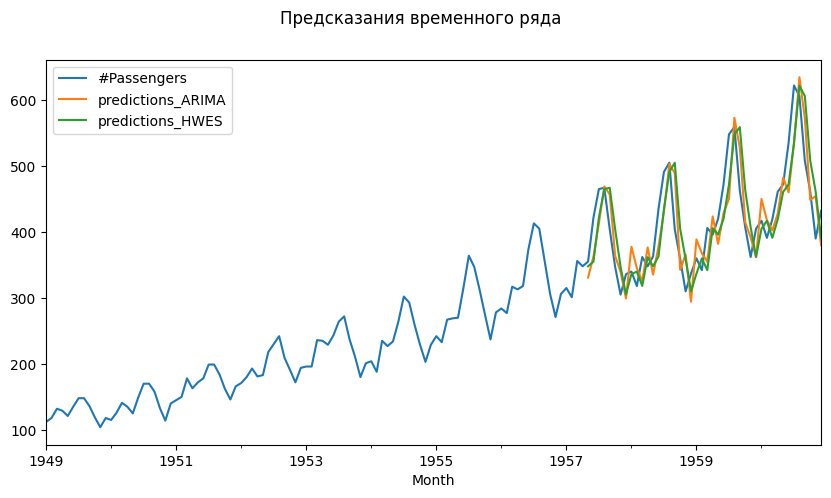

In [243]:
fig, ax = plt.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Предсказания временного ряда')
passengers.plot(ax=ax, legend=True)
plt.show()

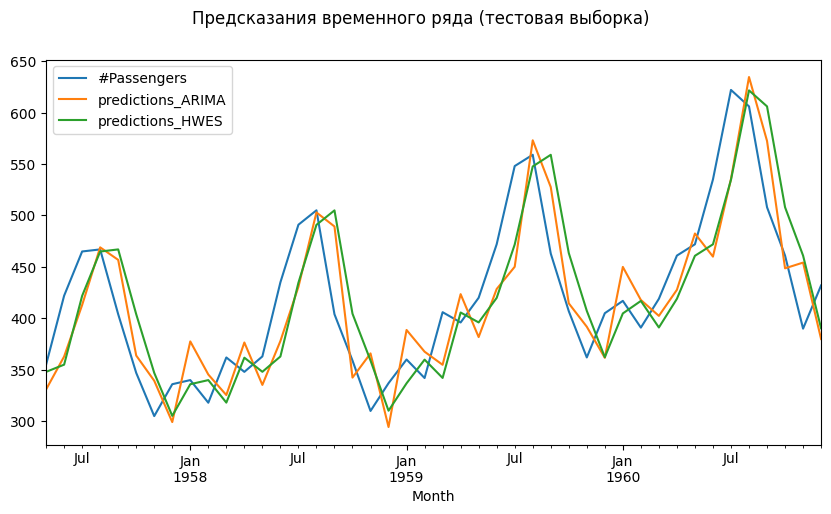

In [244]:
fig, ax = plt.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Предсказания временного ряда (тестовая выборка)')
passengers[train_size:].plot(ax=ax, legend=True)
plt.show()

# Прогнозирование временного ряда методом символьной регресии

In [245]:
function_set = ['add', 'sub', 'mul', 'div', 'sin']
est_gp = SymbolicRegressor(population_size=500, metric='mse',
                               generations=70, stopping_criteria=0.01,
                               init_depth=(4, 10), verbose=1, function_set=function_set,
                               const_range=(-100, 100), random_state=0)

In [246]:
est_gp.fit(np.array(xnum_train).reshape(-1, 1), train.reshape(-1, 1))

c:\Users\miss-\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0   263.65      8.79975e+46       59          4935.14              N/A      2.94m
   1   141.19      4.16457e+14       72          4638.92              N/A      1.33m
   2    73.52      2.25505e+09       78          4579.99              N/A     46.10s
   3    64.77      1.21852e+15       71          3864.76              N/A     42.82s
   4    69.55      1.25496e+11       85          3715.16              N/A     46.49s
   5    68.89      4.26607e+10       81           3012.4              N/A     46.72s
   6    78.37      1.49839e+11       81           3012.4              N/A     50.12s
   7    79.09      8.20465e+13       92          3009.99              N/A     42.43s
   8    92.35      5.15147e+10      129             2754              N/A  

SymbolicRegressor(const_range=(-100, 100),
                  function_set=['add', 'sub', 'mul', 'div', 'sin'],
                  generations=70, init_depth=(4, 10), metric='mse',
                  population_size=500, random_state=0, stopping_criteria=0.01,
                  verbose=1)

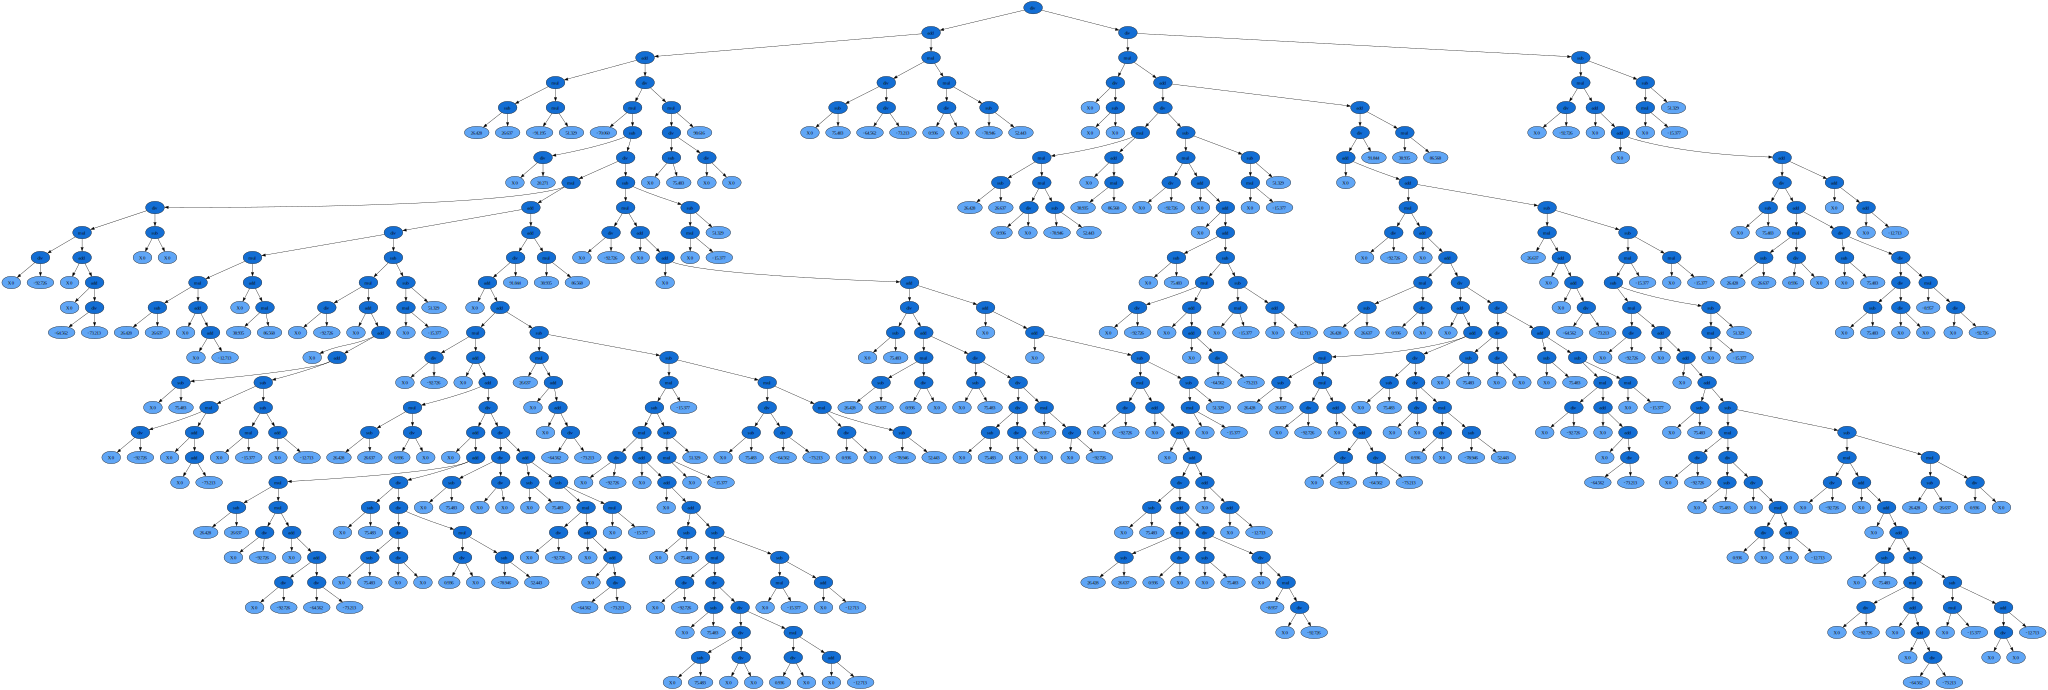

In [247]:
dot_data = est_gp._program.export_graphviz()
graph = graphviz.Source(dot_data)
graph

In [248]:
# Предсказания
y_gp = est_gp.predict(np.array(xnum_test).reshape(-1, 1))
y_gp[:10]

array([337.4146303 , 339.60335004, 341.80088045, 344.00917373,
       346.2293616 , 348.4621579 , 350.70806389, 352.96747737,
       355.24075237, 357.5282324 ])

In [261]:
# Записываем предсказания в DataFrame
passengers['predictions_GPLEARN'] = (train_size * [np.NAN]) + list(y_gp)

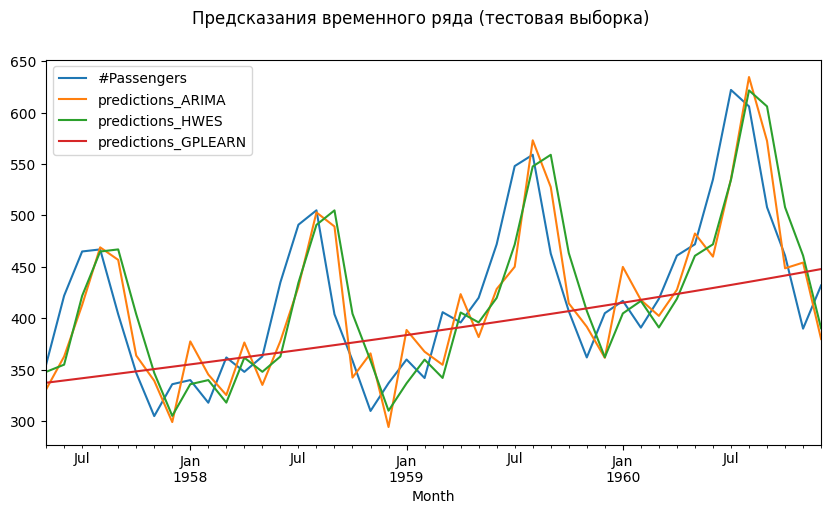

In [262]:
fig, ax = plt.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Предсказания временного ряда (тестовая выборка)')
ts_fb2[train_size:].plot(ax=ax, legend=True)
plt.show()

In [263]:
passengers.head()

,#Passengers,predictions_ARIMA,predictions_HWES,predictions_GPLEARN
Month,,,,
1949-01-01,112,NaN,NaN,NaN
1949-02-01,118,NaN,NaN,NaN
1949-03-01,132,NaN,NaN,NaN
1949-04-01,129,NaN,NaN,NaN
1949-05-01,121,NaN,NaN,NaN


In [254]:
r2_arima = r2_score(passengers[CELEVOY_PRIZNAK][train_size:], passengers['predictions_ARIMA'][train_size:])
f'{round(r2_arima * 100, 3)}%'

'64.913%'

In [255]:
r2_hwes = r2_score(passengers[CELEVOY_PRIZNAK][train_size:], passengers['predictions_HWES'][train_size:])
f'{round(r2_hwes * 100, 3)}%'

'58.162%'

In [264]:
r2_gplearn = r2_score(passengers[CELEVOY_PRIZNAK][train_size:], passengers['predictions_GPLEARN'][train_size:])
f'{round(r2_gplearn * 100, 3)}%'

'6.264%'

In [266]:
mae_arima = mean_absolute_error(passengers[CELEVOY_PRIZNAK][train_size:], passengers['predictions_ARIMA'][train_size:])
mae_arima

39.34071504222961

In [267]:
mae_hwes = mean_absolute_error(passengers[CELEVOY_PRIZNAK][train_size:], passengers['predictions_HWES'][train_size:])
mae_hwes

41.748807674489036

In [268]:
mae_gplearn = mean_absolute_error(passengers[CELEVOY_PRIZNAK][train_size:], passengers['predictions_GPLEARN'][train_size:])
mae_gplearn

53.97152719947599